# Tensorflow with GPU

This notebook provides an introduction to computing on a [GPU](https://cloud.google.com/gpu) in Colab. In this notebook you will connect to a GPU, and then run some basic TensorFlow operations on both the CPU and a GPU, observing the speedup provided by using the GPU.


## Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

In [ ]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
5.611492580999993
GPU (s):
0.06514771800001995
GPU speedup over CPU: 86x


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !ln -s /content/gdrive/My\ Drive/ /mydrive

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Face-recognition-real_time

/content/gdrive/MyDrive/Face-recognition-real_time


In [ ]:
from keras.models import load_model
model = load_model('/content/gdrive/MyDrive/Face-recognition-real_time/facenet_keras.h5', compile=False)
print(model.inputs)
print(model.outputs)

[<KerasTensor: shape=(None, 160, 160, 3) dtype=float32 (created by layer 'input_1')>]
[<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'Bottleneck_BatchNorm')>]


In [ ]:
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 9.3 MB/s 


In [ ]:
import os
import numpy as np
import cv2

from os import listdir
from PIL import Image
from numpy import asarray, savez_compressed, expand_dims, load
from mtcnn.mtcnn import MTCNN
from os import listdir
from os.path import isdir
from keras.models import load_model
from random import choice
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot 
from sklearn.metrics import accuracy_score

In [ ]:
import cv2
import os

def merge_image(back, front, x, y):
    # convert to rgba
    if back.shape[2] == 3:
        back = cv2.cvtColor(back, cv2.COLOR_BGR2BGRA)
    if front.shape[2] == 3:
        front = cv2.cvtColor(front, cv2.COLOR_BGR2BGRA)

    # crop the overlay from both images
    bh, bw = back.shape[:2]
    fh, fw = front.shape[:2]
    x1, x2 = max(x, 0), min(x + fw, bw)
    y1, y2 = max(y, 0), min(y + fh, bh)
    front_cropped = front[y1 - y:y2 - y, x1 - x:x2 - x]
    back_cropped = back[y1:y2, x1:x2]

    alpha_front = front_cropped[:, :, 3:4] / 255
    alpha_back = back_cropped[:, :, 3:4] / 255

    # replace an area in result with overlay
    result = back.copy()
    return result


def make_smaller(img, scale_percent=15):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)

    dsize = (width, height)

    # resize image
    small_image = cv2.resize(img, dsize)
    return small_image


def augment_selfie(img, backg_img):
    img = make_smaller(img)
    res = merge_image(backg_img, img, 150, 150)
    return res


def create_augmented_image(path, background):
    folder, filename = os.path.split(path)
    res = augment_selfie(cv2.imread(path), background)
    os.chdir(folder)
    name, extension = os.path.splitext(filename)
    new_filename = f"{name}_aug{extension}"
    cv2.imwrite(new_filename, res)


def rewrite_to_augmented(path, background):
    folder, filename = os.path.split(path)
    res = augment_selfie(cv2.imread(path), background)
    os.chdir(folder)
    cv2.imwrite(filename, res)


In [ ]:
# from get_embedding import get_embedding
# from face_to_embedings import face_to_embedings
# from augment_selfie import augment_selfie
# from make_smaller import make_smaller
# from merge_image import merge_image
# from extract_face import extract_face
# from augmentation import rewrite_to_augmented
# from load_dataset import load_dataset

['pratham_3.jpg', 'pratham_1.jpg', 'pratham_2.jpg', 'pratham.jpg']
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/pratham/pratham_3.jpg
1 (160, 160, 3)


/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/pratham/pratham_1.jpg
2 (160, 160, 3)


/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/pratham/pratham_2.jpg
3 (160, 160, 3)
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/pratham/pratham.jpg
4 (160, 160, 3)


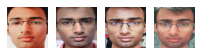

In [ ]:
def extract_face(filename, required_size=(160, 160)):
        """
        Extract a single face from a given photograph
        """
        image = Image.open(filename)
        # convert to RGB, if needed
        image = image.convert('RGB')
        # convert to array
        pixels = asarray(image)
        # create the detector, using default weights
        detector = MTCNN()
        # detect faces in the image
        results = detector.detect_faces(pixels)
        if len(results) == 0:
            return
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        # extract the face
        face = pixels[y1:y2, x1:x2]
        # resize pixels to the model size
        image = Image.fromarray(face)
        image = image.resize(required_size)
        return asarray(image)

folder = '/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/pratham'
i = 1
# # # enumerate files
print(listdir(folder))
for filename in listdir(folder):
    path = os.path.join(folder, filename)
    face = extract_face(path)
    print(path)
    if face is None:
      print(f'I can`t find a person in {filename}!\nI will try to use augmentation.\n')
      back = cv2.imread('backg.jpg')
      rewrite_to_augmented(path, back)
      continue
    print(i, face.shape)
    # plot
    pyplot.subplot(4, 7, i)
    pyplot.axis('off')
    pyplot.imshow(face)
    i += 1
pyplot.show()

In [ ]:
%cd /content/gdrive/MyDrive/Face-recognition-real_time

/content/gdrive/MyDrive/Face-recognition-real_time


In [ ]:
def extract_face(filename, required_size=(160, 160)):
        """
        Extract a single face from a given photograph
        """
        image = Image.open(filename)
        # convert to RGB, if needed
        image = image.convert('RGB')
        # convert to array
        pixels = asarray(image)
        # create the detector, using default weights
        detector = MTCNN()
        # detect faces in the image
        results = detector.detect_faces(pixels)
        if len(results) == 0:
            return
        x1, y1, width, height = results[0]['box']
        x1, y1 = abs(x1), abs(y1)
        x2, y2 = x1 + width, y1 + height
        # extract the face
        face = pixels[y1:y2, x1:x2]
        # resize pixels to the model size
        image = Image.fromarray(face)
        image = image.resize(required_size)
        return asarray(image)

def load_faces( directory):
        """
        Load images and extract faces for all images in a directory
        """
        faces = []
        # enumerate files
        for filename in listdir(directory):
            path = directory + filename
            print(path)
            # get face or augment it
            face = extract_face(path)
            if face is None:
                print(f'I can`t find a person in {filename}!\nI will try to use augmentation.\n')
                back = cv2.imread('backg.jpg')
                rewrite_to_augmented(path, back)
                continue
            faces.append(face)
        return faces
def load_dataset(directory):
        """Load a dataset that contains one subdir for each
         class that in turn contains images."""
        X, y = [], []
        # enumerate all folders named with class labels
        for subdir in listdir(directory):
            path = directory + subdir + '/'
            # print(path)
            # skip any files that might be in the dir
            if not isdir(path):   
                continue
            # print("check")
            # load all faces in the subdirectory
            faces = load_faces(path)
            # create labels
            labels = [subdir for _ in range(len(faces))]
            print(f">loaded {len(faces)} examples for class: {subdir}")
            X.extend(faces)
            y.extend(labels)
        return asarray(X), asarray(y)


train_X, train_Y = load_dataset('/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/')
print(train_X.shape, train_Y.shape)

savez_compressed('face_train_dataset.npz', train_X, train_Y)# save arrays to one file in compressed format


/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/03e2f2eecd.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/77f44d36bd.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/17d941409e.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/5b06357520.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/43eec300bc.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/394fc0ac04.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/26ed5508bb.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/50a230dbfc.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/53ad4d1128.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/train/johnny_lever/4f3d03e5e9.jpg
/content/g

In [ ]:
test_X, test_Y = load_dataset('/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/')
savez_compressed('face_test_dataset.npz', test_X, test_Y)

/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/61fb065916.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/83ba353a87.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/229a690a48.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/72afbb47a3.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/75b5e032ef.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/74f37c06ac.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/78a1ff02b9.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/74ead4fd4d.jpg
/content/gdrive/MyDrive/Face-recognition-real_time/faces_dataset/val/ayushmann_khurrana/55b535ce9a.jpg
>loaded 9 examples for class: ayushmann_khurrana
/content/gdrive/MyDrive/

In [ ]:
# calculate a face embedding for each face in the dataset using facenet
def get_embedding(model, face_pixels):
        """Get the face embedding for one face"""
        # scale pixel values
        face_pixels = face_pixels.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        # transform face into one sample
        samples = expand_dims(face_pixels, axis=0)
        # make prediction to get embedding
        yhat = model.predict(samples)
        return yhat[0]

def face_to_embedings(faces, model):
        """Convert each face in the train set to an embedding."""
        embedings = []
        for face_pixels in faces:
            embedding = get_embedding(model, face_pixels)
            embedings.append(embedding)
        embedings = asarray(embedings)
        return embedings


train = load('face_train_dataset.npz')
test = load('face_test_dataset.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
load_model('/content/gdrive/MyDrive/Face-recognition-real_time/facenet_keras.h5',compile=False)
newTrainX = face_to_embedings(train_X, model)
newTestX = face_to_embedings(test_X, model)
savez_compressed('face_train_embeddings.npz', newTrainX, train_Y)
savez_compressed('face_test_embeddings.npz',  newTestX, test_Y)

In [ ]:
print('Loaded: ', train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)
print('Loaded Model')
print(newTrainX.shape)
print(newTestX.shape)

Loaded:  (511, 160, 160, 3) (511,) (94, 160, 160, 3) (94,)
Loaded Model
(511, 128)
(94, 128)


In [ ]:
train = load('face_train_embeddings.npz')
test = load('face_test_embeddings.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
print(f'Dataset: train={train_X.shape[0]}, test={test_X.shape[0]}')

# normalize input vectors
in_encoder = Normalizer(norm='l2')

# print(train_X)
# print(test_X)
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)

# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(train_Y)
train_Y = out_encoder.transform(train_Y)
test_Y = out_encoder.transform(test_Y)
model = SVC(kernel='linear', probability=True)
model.fit(train_X, train_Y)
yhat_train = model.predict(train_X)
yhat_test = model.predict(test_X)
score_train = accuracy_score(train_Y, yhat_train)
score_test = accuracy_score(test_Y, yhat_test)

print(f'Accuracy: train={score_train * 100:.3f}, test={score_test * 100:.3f}')

Dataset: train=511, test=94
Accuracy: train=99.609, test=98.936


Predicted: johnny_lever 87.139
Expected: johnny_lever


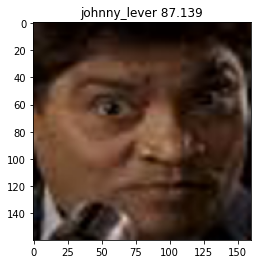

In [ ]:
test = load('face_test_dataset.npz')
testX_faces = test['arr_0']
train = load('face_train_embeddings.npz')
test = load('face_test_embeddings.npz')
train_X, train_Y, test_X, test_Y = train['arr_0'], train['arr_1'], test['arr_0'], test['arr_1']
in_encoder = Normalizer(norm='l2')
train_X = in_encoder.transform(train_X)
test_X = in_encoder.transform(test_X)
out_encoder = LabelEncoder()
out_encoder.fit(train_Y)
train_Y = out_encoder.transform(train_Y)
test_Y = out_encoder.transform(test_Y)
model = SVC(kernel='linear', probability=True)
model.fit(train_X, train_Y)

# model.save("/content/gdrive/MyDrive/Face-recognition-real_time/faceReco")

selection = choice([i for i in range(test_X.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = test_X[selection]
random_face_class = test_Y[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print(f'Predicted: {predict_names[0]} {class_probability:.3f}')
print(f'Expected: {random_face_name[0]}' )
pyplot.imshow(random_face_pixels)
title = f'{predict_names[0]} {class_probability:.3f}'
pyplot.title(title)
pyplot.show()

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

name 'take_photo' is not defined


error: ignored